# SALIENCYMIX: A SALIENCY GUIDED DATA AUGMENTATION STRATEGY FOR BETTER REGULARIZATION

## 1. How to augment the data

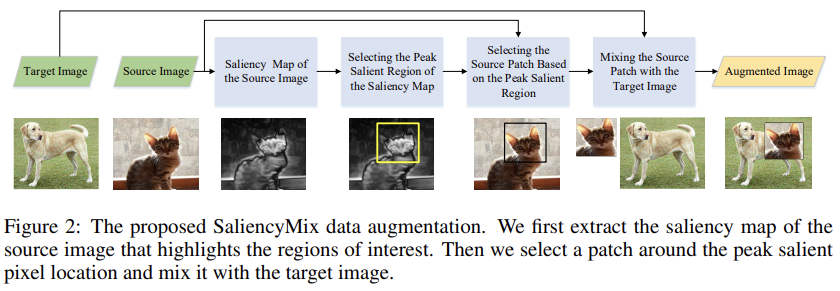

In [9]:
import numpy as np

import torch
from torchvision import datasets, transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

### Target Image

--2023-05-31 09:53:21--  https://image.dongascience.com/Photo/2022/06/6982fdc1054c503af88bdefeeb7c8fa8.jpg
Resolving image.dongascience.com (image.dongascience.com)... 211.43.210.30
Connecting to image.dongascience.com (image.dongascience.com)|211.43.210.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115603 (113K) [image/jpeg]
Saving to: ‘6982fdc1054c503af88bdefeeb7c8fa8.jpg’

6982fdc1054c503af88 100%[===================>] 112.89K   145KB/s    in 0.8s    

2023-05-31 09:53:24 (145 KB/s) - ‘6982fdc1054c503af88bdefeeb7c8fa8.jpg’ saved [115603/115603]



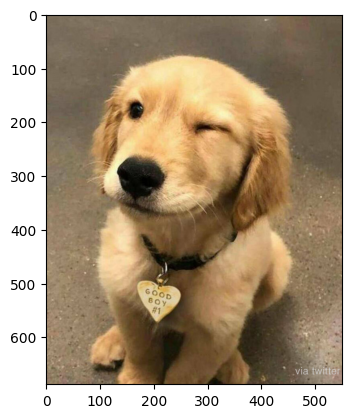

In [10]:
!wget https://image.dongascience.com/Photo/2022/06/6982fdc1054c503af88bdefeeb7c8fa8.jpg

!mv 6982fdc1054c503af88bdefeeb7c8fa8.jpg img1.jpg

img1 = Image.open("./img1.jpg")
plt.imshow(img1)  

### Source Image

--2023-05-31 09:53:24--  https://image.fmkorea.com/files/attach/new/20200526/486616/799739237/2920986115/87f4a1c3846976c43bd7d42ed90004a8.jpeg
Resolving image.fmkorea.com (image.fmkorea.com)... 92.223.84.84
Connecting to image.fmkorea.com (image.fmkorea.com)|92.223.84.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80512 (79K) [image/jpeg]
Saving to: ‘87f4a1c3846976c43bd7d42ed90004a8.jpeg’

87f4a1c3846976c43bd 100%[===================>]  78.62K  --.-KB/s    in 0.004s  

2023-05-31 09:53:24 (17.7 MB/s) - ‘87f4a1c3846976c43bd7d42ed90004a8.jpeg’ saved [80512/80512]



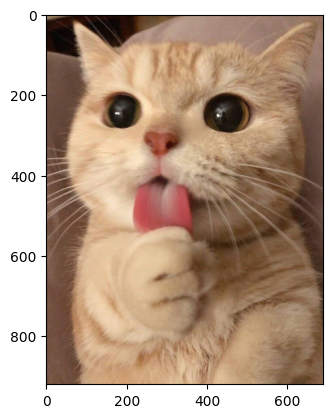

In [11]:
!wget https://image.fmkorea.com/files/attach/new/20200526/486616/799739237/2920986115/87f4a1c3846976c43bd7d42ed90004a8.jpeg

!mv 87f4a1c3846976c43bd7d42ed90004a8.jpeg img2.jpg

img2 = Image.open("./img2.jpg")
plt.imshow(img2)  

In [12]:
preprocess = T.Compose([
   T.ToTensor(),
  T.Resize((600,450)),
 
])


target = preprocess(img1) 
source = preprocess(img2) 

In [13]:
def saliency_bbox(img, lam=np.random.beta(1,1)):
    size = img.size() # Get the size of the image
    W = size[1] # Width of the image
    H = size[2] # Height of the image

    # Calculate the cut ratios based on lambda value
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int_(W * cut_rat)
    cut_h = np.int_(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and
    # compute the saliency map

    # Convert the image to a format compatible with OpenCV
    temp_img = img.cpu().numpy().transpose(1, 2, 0) 

    # Initialize OpenCV's static fine grained saliency detector
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    
    # Compute the saliency map using the detector
    (success, saliencyMap) = saliency.computeSaliency(temp_img)

    # Scale the saliency map to the range [0, 255] and convert to uint8
    saliencyMap = (saliencyMap * 255).astype("uint8")

    # Save the saliency map as an image file
    cv2.imwrite(os.path.join(os.getcwd(),"saliencyMap.jpg"), saliencyMap)

    # Find the maximum value's indices in the saliency map
    maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
    x = maximum_indices[0]
    y = maximum_indices[1]

    # Calculate the coordinates of the bounding box
    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [14]:
bbx1, bby1, bbx2, bby2 = saliency_bbox(source)
print(bbx1, bby1, bbx2, bby2)
target[:, bbx1:bbx2, bby1:bby2] = source[:, bbx1:bbx2, bby1:bby2]

0 0 178 192


### Saliency Map

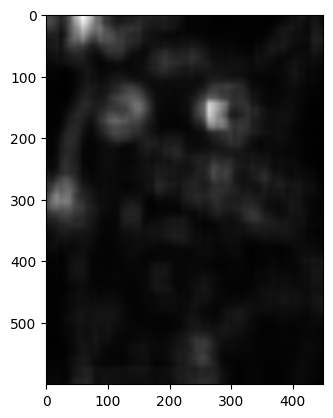

In [15]:
import matplotlib.image as mpimg

plt.imshow(mpimg.imread('saliencyMap.jpg'), cmap='gray')

### Augmented Image

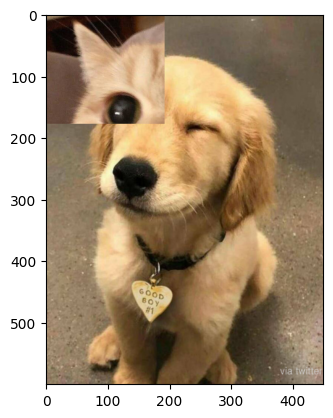

In [16]:
plt.imshow(target.permute(1,2,0))

## 2. How to train the ResNet model



*   dataset : CIFAR-10
*   model : WideResnet



#### code download

In [17]:
!git clone https://github.com/afm-shahab-uddin/SaliencyMix.git

Cloning into 'SaliencyMix'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 168 (delta 2), reused 1 (delta 0), pack-reused 157
Receiving objects: 100% (168/168), 69.19 KiB | 5.32 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [18]:
%cd '/content/SaliencyMix/SaliencyMix_CIFAR' 

/content/SaliencyMix/SaliencyMix_CIFAR


#### train 1 epoch & test

In [19]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms

#from util.misc import CSVLogger

from model.resnet import ResNet18, ResNet50, ResNet101
from model.wide_resnet import WideResNet

import os
import cv2
'''
CUDA_VISIBLE_DEVICES=0,1 python saliencymix.py \
--dataset cifar10 \
--model wideresnet \
--beta 1.0 \
--salmix_prob 0.5 \
--batch_size 128 \
--data_augmentation \
--learning_rate 0.1
'''
# hyperparameters

beta=1.0
salmix_prob=0.5
batch_size=128
learning_rate=0.1
epochs=1

args={'model':'wideresnet', 'data':'CIFAR-10'}

cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(0)
torch.cuda.manual_seed(0)

test_id = 'cifar10' + '_' + 'wideresnet'


normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])

train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

num_classes = 10
train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

cnn = WideResNet(depth=28, num_classes=num_classes, widen_factor=10,
                         dropRate=0.3)
# cnn = cnn.cuda()
cnn = nn.DataParallel(cnn).cuda()
criterion = nn.CrossEntropyLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)


scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)



def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = (correct / total)*100
    cnn.train()
    return val_acc


def saliency_bbox(img, lam):
    size = img.size()
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int_(W * cut_rat)
    cut_h = np.int_(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and
    # compute the saliency map
    temp_img = img.cpu().numpy().transpose(1, 2, 0)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(temp_img)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
    x = maximum_indices[0]
    y = maximum_indices[1]

    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


best_accuracy = 0
best_acc_epoch = 0

for epoch in range(epochs):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch+1))

        images = images.cuda()
        labels = labels.cuda()

        r = np.random.rand(1)
        if beta > 0 and r < salmix_prob:
            # generate mixed sample
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(images.size()[0]).cuda()
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = saliency_bbox(images[rand_index[0]], lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))

            # compute output
            cnn.zero_grad()
            pred = cnn(images)
            xentropy_loss = criterion(pred, labels_a)* lam + criterion(pred, labels_b) * (1. - lam)
        else:
            cnn.zero_grad()
            pred = cnn(images)
            xentropy_loss = criterion(pred, labels)

        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = (correct / total)*100

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step(epoch)

    row = {'epoch': str(epoch+1), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    print(row)

    if(test_acc>best_accuracy):
        best_accuracy = test_acc
        best_acc_epoch = epoch+1

# Create checkpoints Directory if does exist
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

torch.save(cnn.state_dict(), 'checkpoints/' + test_id + '.pt')

print('\n\n*best_accuracy*-----------------------------')
print('best acc: %.3f at iteration: %d \r\n' % (best_accuracy, best_acc_epoch))

100%|██████████| 170498071/170498071 [00:05<00:00, 29237961.33it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s, acc=36.332, xentropy=1.781]


test_acc: 49.700
{'epoch': '1', 'train_acc': '36.332', 'test_acc': '49.7'}


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)




*best_accuracy*-----------------------------
best acc: 49.700 at iteration: 1 

